# Analisando os microdados do ENEM 2019

Por **Kauvin Lucas**

In [ ]:
# Instalar algums comandos adicionais
!apt-get update
!apt-get install wget unzip -y

In [1]:
# Criar a pasta data
!mkdir /mnt/assets/data

In [ ]:
# Descarregar os microdados ENEM 2019, arquivos geoespaciais e dados do IBGE para data
!wget https://download.inep.gov.br/microdados/microdados_enem_2019.zip -P /mnt/assets/data
!wget https://github.com/datalivre/Conjunto-de-Dados/raw/master/br_states.json -P /mnt/assets/data
!wget https://www.ibge.gov.br/exportacao/6f2560506cccdf1d3f9b2ef7783803f3.csv -P /mnt/assets/data
!unzip -j /mnt/assets/data/microdados_enem_2019.zip DADOS/MICRODADOS_ENEM_2019.csv

In [ ]:
# Instalar módulos faltantes
!pip install tdqm folium
!pip install --upgrade scikit-learn
!pip install xgboost

In [4]:
# Importar os módulos do PySpark
from pyspark.sql.types import *
from pyspark.sql.functions import when, col

# Importar os módulos estadísticos e de visualização
import pandas as pd
import numpy as np
import statsmodels.api as sn
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import folium
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

# Importar outros módulos úteis
from operator import add
from functools import reduce
import os
from tqdm.notebook import tqdm_notebook
import warnings
warnings.filterwarnings("ignore")

## 1. Introdução
O Exame Nacional do Ensino Médio (ENEM) é um exame padronizado de escala nacional usado para avaliar o dominio dos participantes que finalizaram ou estão por finalizar o ensino médio nas áreas da ciência, tecnologia e linguagem no Brasil. Além de viabilizar o acesso por parte dos participantes ao ensino superior, a prova também reflete a realidade socioeconômica em que cada um deles vivem.

O presente projeto tem por finalidade explorar os microdados do ENEM 2019 do Instituto Nacional de Estudos e Pesquisas Educacionais Anísio Teixeira (2019) através de uma análise exploratória de dados e uso de algoritmo de regressão, e identificar algumas das variáveis que são mais incidem nas notas da prova, com o intuito de derivar padrões preditivos que guiarão políticas públicas respeito à educação no Brasil.

## 2. Revisão da literatura
Uma das tentativas para descrever os aspectos socioeconômicos do ENEM e o seu impacto nas notas das provas foram realizadas por Melo et al. (2021) mediante um estudo espacial e sociológico, no qual intentaram identificar variáveis com maior impacto no desempenho dos municípios nas médias e variâncias das notas do ENEM 2018. Os autores utilizaram a técnica de regressão linear múltipla com o método Least Absolute Shrinkage and Selection Operator (LASSO) para selecionar as variáveis independentes que têm alguma influência nas variáveis de média e variância das provas de redação e objetiva. Tal estudo conseguiu destacar as disparidades socioeconômicas refletidas nas contribuições da sociologia da educação protagonizadas por Pierre Bourdieu (1930-2002).

## 3. Descrição do problema.
Uma análise dos fatores que influenciaram nas notas do ENEM poderia retratar as diversas desigualdades educacionais presentes no país que permitirão avaliar a efetividade das políticas públicas para a educação brasileira. Por tanto, é necessario identificar estes fatores por meio de uma exploração estadística dos dados e interpretar-los dentro de um contexto socioeconômico relevante e atual.

## 4. Objetivos específicos.
* Explorar as médias e dispersões das notas em cada estado e região do país.
* Identificar e estudar as variáveis que exerceram maior influência nas notas das provas mediante um algoritmo de regressão pela técnica de *gradient boosting*.

## 5. Descrição dos dados.
Os microdados do ENEM 2019 consistem de 5.095.270 observações e 136 atributos. 25 desses atributos são referentes às questões de um questionário que indaga aspectos sobre nível socioeconômico, família, educação e trabalho dos participantes. As notas de cada participante das provas de Ciências Naturais, Ciências Humanas, Linguagens e Códigos, Matemática e Redação estão representadas respectivamente pelas colunas `NU_NOTA_CN`, `NU_NOTA_CH`, `NU_NOTA_LC`, `NU_NOTA_MT` e `NU_NOTA_REDACAO`. As outras varíaveis relevantes representam nformações gerais sobre a realização das provas e a caracterização do participante e da escola que ele declarou ter frequentado, tais como idade, nacionalidade, necessidade de atendimento especial, etc.

Para cumprir com os objetivos do projeto, se tomou como variável de saída a média aritmética das notas de todas as provas. Para explorar as dispersões das notas em cada estado e região, se trabalhou com dados geoespaciais apartir da variável `SG_UF_NASCIMENTO`, que representa cada Unidade Federativa do Brasil.

## 6. Transformação dos dados
### 6.1. Exploração e limpeza dos dados

Ao descrever atributos numéricos (tabela a seguir), percebe-se a presença de muitos dados faltantes. Em algumas variáveis, tais como `CO_ESCOLA`, os dados faltantes são devido à falta de informação respeito à escola em que os participantes se encontram ou se encontravam ao momento de realizar as provas. Como não é possível inputar-los ou excluir-los, estes foram considerados como valores desconhecidos durante a analise.

In [2]:
# Criar um dataframe
df = spark.read.options(header='True', inferSchema='True', delimiter=';')\
    .csv("file:///mnt/assets/data/MICRODADOS_ENEM_2019.csv")

# Descrever atributos numéricos
pd.set_option('display.max_rows', None)
numeric_features = [t[0] for t in df.dtypes if t[1] == 'int' or t[1] == 'double']
df.select(numeric_features).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
NU_ANO,5095270,2019.0,0.0,2019,2019
CO_MUNICIPIO_RESIDENCIA,5095270,3086472.4672313733,997360.415429331,1100015,5300108
CO_UF_RESIDENCIA,5095270,30.714074033368203,9.943231127628104,11,53
NU_IDADE,5095201,22.08764325489809,7.454793312005096,10,94
TP_ESTADO_CIVIL,5095270,1.075275893132258,0.4388921371300876,0,4
TP_COR_RACA,5095270,2.128251103474399,1.0175120935552757,0,5
TP_NACIONALIDADE,5095270,1.0302539414005538,0.2097909867493207,0,4
CO_MUNICIPIO_NASCIMENTO,4950021,3059766.106359549,984026.3441643384,1100015,5300108
CO_UF_NASCIMENTO,4950021,30.446578711484253,9.806732559276076,11,53


Os valores faltantes nas colunas representando as notas indicariam ausência e não reaplicação na prova, razão pela qual foram excluídas as respectivas observações do conjunto de dados.

Foram removidos algums atributos irrelevantes à simples vista, entre ellas os dados da escola de cada participante, para que o processamento dos dados seja mais rápido. O argumento para a exclusão dos dados da escola tem a ver com ambigüidade no significado (um mesmo aluno poderia ou não ter cursado em escola pública e privada durante o ensino médio) e com a enorme quantidade de dados faltantes nesses atributos, o que atrapalharia na analise dos dados.

Além disso, as observações cujas notas das provas de redação não foram de aprovação e cujos alunos foram eliminados ou faltaram as provas foram excluídas do conjunto de dados, já que o enfoque seria somente nos participantes aprovados.

In [3]:
length = len(df.columns)

# Remover valores faltantes nas variáveis das notas
df = df.dropna(subset=["NU_NOTA_CN", "NU_NOTA_CH", "NU_NOTA_MT", "NU_NOTA_LC", "NU_NOTA_REDACAO"])

# Filtrar participantes que não aprovaram as provas
df = df.filter((df["TP_STATUS_REDACAO"]  == "1")
               & (df["TP_PRESENCA_CN"]  == "1")
               & (df["TP_PRESENCA_CH"]  == "1")
               & (df["TP_PRESENCA_LC"]  == "1")
               & (df["TP_PRESENCA_MT"]  == "1"))

# Excluir atributos irrelevantes ao problema
df = df.drop("NU_INSCRICAO", "NU_ANO", "CO_MUNICIPIO_RESIDENCIA", "NO_MUNICIPIO_RESIDENCIA", 
               "CO_UF_RESIDENCIA", "CO_MUNICIPIO_NASCIMENTO", "CO_UF_NASCIMENTO", "TP_ESCOLA", 
               "TP_ENSINO", "CO_ESCOLA", "CO_MUNICIPIO_ESC", "NO_MUNICIPIO_ESC", "CO_UF_ESC", 
               "SG_UF_ESC", "TP_DEPENDENCIA_ADM_ESC", "TP_LOCALIZACAO_ESC", "TP_SIT_FUNC_ESC", 
               "CO_MUNICIPIO_PROVA", "CO_UF_PROVA", "TP_PRESENCA_CN", "TP_PRESENCA_CH", 
               "TP_PRESENCA_LC", "TP_PRESENCA_MT", "CO_PROVA_CN", "CO_PROVA_CH", "CO_PROVA_LC", 
               "CO_PROVA_MT", "TX_RESPOSTAS_CN", "TX_RESPOSTAS_CH", "TX_RESPOSTAS_LC", "TX_RESPOSTAS_MT", 
               "TX_GABARITO_CN", "TX_GABARITO_CH", "TX_GABARITO_LC", "TX_GABARITO_MT", "NU_NOTA_COMP1", 
               "NU_NOTA_COMP2", "NU_NOTA_COMP3", "NU_NOTA_COMP4", "NU_NOTA_COMP4", "NU_NOTA_COMP5", 
               "NO_MUNICIPIO_PROVA", "TP_PRESENCA_CN", "TP_PRESENCA_CH", "TP_PRESENCA_LC", 
               "TP_PRESENCA_MT", "NO_MUNICIPIO_NASCIMENTO", "TP_STATUS_REDACAO")

print("O total de atributos reduziu-se de {} a {}".format(length, len(df.columns)))

O total de atributos reduziu-se de 136 a 93


### 6.2. Transformação e redução dos atributos (feature engineering)
A seguir descrevo algumas das ideias de transformação dos atributos que surgiram durante o projeto:
* Conversão dos atributos relacionados aos dados dos pedidos de recursos especializados e específicos para a realização das provas em um único atributo.
* Cálculo das médias de notas de todas as provas.

A conversão dos atributos relacionados aos dados dos pedidos de recursos especializados e específicos para a realização das provas foi feita atribuindo com o valor de **1** à observação cujo participante solicitou o recurso para atendimento especializado e **0** se não fez a solicitação. Os valores resultantes dessa transformação foram gravados numa nova coluna chamada `RECURSO_ESPECIALIZADO`.

In [4]:
length = len(df.columns)
recursos_esp = ['IN_TREINEIRO', 'IN_BAIXA_VISAO', 'IN_CEGUEIRA', 'IN_SURDEZ', 'IN_DEFICIENCIA_AUDITIVA',
                'IN_SURDO_CEGUEIRA', 'IN_DEFICIENCIA_FISICA', 'IN_DEFICIENCIA_MENTAL', 'IN_DEFICIT_ATENCAO',
                'IN_DISLEXIA', 'IN_DISCALCULIA', 'IN_AUTISMO', 'IN_VISAO_MONOCULAR', 'IN_OUTRA_DEF','IN_GESTANTE',
                'IN_LACTANTE','IN_IDOSO', 'IN_ESTUDA_CLASSE_HOSPITALAR', 'IN_SEM_RECURSO', 'IN_BRAILLE',
                'IN_AMPLIADA_24','IN_AMPLIADA_18', 'IN_LEDOR', 'IN_ACESSO', 'IN_TRANSCRICAO', 'IN_LIBRAS',
                'IN_TEMPO_ADICIONAL', 'IN_LEITURA_LABIAL', 'IN_MESA_CADEIRA_RODAS', 'IN_MESA_CADEIRA_SEPARADA',
                'IN_APOIO_PERNA', 'IN_GUIA_INTERPRETE', 'IN_COMPUTADOR', 'IN_CADEIRA_ESPECIAL',
                'IN_CADEIRA_CANHOTO','IN_CADEIRA_ACOLCHOADA', 'IN_PROVA_DEITADO', 'IN_MOBILIARIO_OBESO',
                'IN_LAMINA_OVERLAY', 'IN_PROTETOR_AURICULAR', 'IN_MEDIDOR_GLICOSE', 'IN_MAQUINA_BRAILE',
                'IN_SOROBAN', 'IN_MARCA_PASSO', 'IN_SONDA', 'IN_MEDICAMENTOS', 'IN_SALA_INDIVIDUAL',
                'IN_SALA_ESPECIAL', 'IN_SALA_ACOMPANHANTE', 'IN_MOBILIARIO_ESPECIFICO', 'IN_MATERIAL_ESPECIFICO',
                'IN_NOME_SOCIAL']

# Criação da coluna 'TP_RECURSO_ESPECIALIZADO'
df = df.withColumn('TP_RECURSO_ESPECIALIZADO', 
                    when(reduce(add, [col(x) for x in recursos_esp]) == 0, 0).otherwise(1))

# Exclusão dos atributos relacionados aos dados dos pedidos de recursos especializados e específicos
df = df.drop('IN_TREINEIRO', 'IN_BAIXA_VISAO', 'IN_CEGUEIRA', 'IN_SURDEZ', 'IN_DEFICIENCIA_AUDITIVA',
                'IN_SURDO_CEGUEIRA', 'IN_DEFICIENCIA_FISICA', 'IN_DEFICIENCIA_MENTAL', 'IN_DEFICIT_ATENCAO',
                'IN_DISLEXIA', 'IN_DISCALCULIA', 'IN_AUTISMO', 'IN_VISAO_MONOCULAR', 'IN_OUTRA_DEF','IN_GESTANTE',
                'IN_LACTANTE','IN_IDOSO', 'IN_ESTUDA_CLASSE_HOSPITALAR', 'IN_SEM_RECURSO', 'IN_BRAILLE',
                'IN_AMPLIADA_24','IN_AMPLIADA_18', 'IN_LEDOR', 'IN_ACESSO', 'IN_TRANSCRICAO', 'IN_LIBRAS',
                'IN_TEMPO_ADICIONAL', 'IN_LEITURA_LABIAL', 'IN_MESA_CADEIRA_RODAS', 'IN_MESA_CADEIRA_SEPARADA',
                'IN_APOIO_PERNA', 'IN_GUIA_INTERPRETE', 'IN_COMPUTADOR', 'IN_CADEIRA_ESPECIAL',
                'IN_CADEIRA_CANHOTO','IN_CADEIRA_ACOLCHOADA', 'IN_PROVA_DEITADO', 'IN_MOBILIARIO_OBESO',
                'IN_LAMINA_OVERLAY', 'IN_PROTETOR_AURICULAR', 'IN_MEDIDOR_GLICOSE', 'IN_MAQUINA_BRAILE',
                'IN_SOROBAN', 'IN_MARCA_PASSO', 'IN_SONDA', 'IN_MEDICAMENTOS', 'IN_SALA_INDIVIDUAL',
                'IN_SALA_ESPECIAL', 'IN_SALA_ACOMPANHANTE', 'IN_MOBILIARIO_ESPECIFICO', 'IN_MATERIAL_ESPECIFICO',
                'IN_NOME_SOCIAL')
print("O total de atributos reduziu-se de {} a {}".format(length, len(df.columns)))

O total de atributos reduziu-se de 93 a 42


A média de todas as provas foram calculadas e representadas numa nova coluna chamada `MEDIA_NOTAS`

In [5]:
length = len(df.columns)
notas_col = [col("NU_NOTA_CN"), col("NU_NOTA_CH"), col("NU_NOTA_LC"), col("NU_NOTA_MT"), col("NU_NOTA_REDACAO")]
average_func = sum(x for x in notas_col)/len(notas_col)
df = df.withColumn("TP_MEDIA_NOTAS", average_func)
df = df.drop("NU_NOTA_CN", "NU_NOTA_CH", "NU_NOTA_LC", "NU_NOTA_MT", "NU_NOTA_REDACAO")
print("O total de atributos reduziu-se de {} a {}".format(length, len(df.columns)))

O total de atributos reduziu-se de 42 a 38


### 6.3. Amostragem

Nesta etapa foi selecionado uma amostra aleatória estratificada de 30% que é representativa de cada Unidade da Federação do Brasil. O objetivo dessa etapa foi reducir razoavelmente a quantidade de observações para realizar as analises posteriores sem incorrer em falta de espaço na memória.

In [6]:
# Determinar porcentagem da população para amostragem
por = 0.3

# Amostragem pelo método sampleBy
df = df.sampleBy('SG_UF_RESIDENCIA', fractions={'TO':por, 'MG':por, 'MT':por, 'BA':por, 'SP':por, 'RN':por, 
                                                'PR':por, 'CE':por, 'MA':por, 'DF':por, 'AP':por, 'RS':por, 
                                                'PE':por, 'PB':por, 'AM':por, 'RJ':por, 'PA':por, 'GO':por, 
                                                'PI':por, 'SE':por, 'MS':por, 'RO':por, 'ES':por, 'AL':por, 
                                                'SC':por, 'AC':por, 'RR':por}, seed=1234)

Depois de levar a cabo todo o processo de leitura e transformação dos dados com o Spark, foi escrito de volta os dados transformados em um único arquivo em formato parquet para depois ser manipulado pelo módulos estadísticos e de Machine Learning.

In [8]:
df.write.options(header='True', delimiter=';', compression="none")\
        .parquet("file:///mnt/assets/data/enem_transformed_data")
del df

### 7. Carregamento e pré-processamento dos dados

Além dos microdados do ENEM transformados, foram carregados dados relacionados aos indicadores principais do Instituto Brasileiro de Geografia e Estatística (IBGE) por estado do Brasil para análise e dados geoespaciais (geojson) para os mapas cloropléticos.

Antes de proceder ao pré-processamento dos dados, os nomes das colunas referentes ao questionário sobre o aspecto socioeconômico, familiar, de educação e de trabalho dos participantes (`Q001`, `Q002`, ..., `Q025`) foram alterados para os nomes que melhor descrevem as observações.

Na primeira etapa de pré-processamento, as observações resultantes do questionário (com a exceção dos dados relacionados à questão 5) foram transformados em números ordinais. Por sua vez, a variável `TP_SEXO` foi transformada pela técnica de codificação One Hot. 

Já na segunda etapa, as variáveis de interesse para o algoritmo de regressão foram selecionadas depois de uma análise descritiva dos mesmos.

In [5]:
# Fazer a leitura dos arquivos parquet gerados pelo Spark

class leitura_parquet():
    """Define os objetos que irão auxiliar na leitura eficiente e processamento das partições dos 
    dados em parquet."""
    def __init__(self, diretorio):
        self.parquet_files = [diretorio+i 
                              for i in os.listdir(diretorio) 
                              if i.endswith(".parquet")]
        self.dtypes = {'NU_IDADE':'float16', 'TP_SEXO':'category', 'TP_ESTADO_CIVIL':'uint8',
       'TP_COR_RACA':'uint8', 'TP_NACIONALIDADE':'uint8', 'TP_ST_CONCLUSAO':'uint8', 'TP_ANO_CONCLUIU':'uint8', 
        'TP_LINGUA':'uint8', 'Q001':'category', 'Q002':'category','Q003':'category', 'Q004':'category', 
       'Q005':'uint32', 'Q006':'category', 'Q007':'category', 'Q008':'category', 'Q009':'category',
       'Q010':'category', 'Q011':'category', 'Q012':'category', 'Q013':'category', 'Q014':'category', 
        'Q015':'category', 'Q016':'category', 'Q017':'category', 'Q018':'category',
       'Q019':'category', 'Q020':'category', 'Q021':'category', 'Q022':'category', 'Q023':'category', 
       'Q024':'category', 'Q025':'category', 'TP_RECURSO_ESPECIALIZADO':'uint8', 'TP_MEDIA_NOTAS':'float16'}
        self.df = pd.DataFrame(columns=['SG_UF_RESIDENCIA', 'NU_IDADE', 'TP_SEXO', 'TP_ESTADO_CIVIL',
       'TP_COR_RACA', 'TP_NACIONALIDADE', 'SG_UF_NASCIMENTO',
       'TP_ST_CONCLUSAO', 'TP_ANO_CONCLUIU', 'SG_UF_PROVA', 'TP_LINGUA',
       'Q001', 'Q002', 'Q003', 'Q004', 'Q005', 'Q006', 'Q007', 'Q008', 'Q009',
       'Q010', 'Q011', 'Q012', 'Q013', 'Q014', 'Q015', 'Q016', 'Q017', 'Q018',
       'Q019', 'Q020', 'Q021', 'Q022', 'Q023', 'Q024', 'Q025',
       'TP_RECURSO_ESPECIALIZADO', 'TP_MEDIA_NOTAS'])
        self.df = self.df.astype(dtype=self.dtypes)
    def carregar(self, index):
        """Faz a leitura do parquet indicado pelo index dentro do diretório."""
        return pd.read_parquet(self.parquet_files[index])
    def mudar_tipo(self, df_temp):
        """Faz a mudança do tipo de cada coluna de dados para um tipo mais leve e eficiente."""
        return df_temp.astype(dtype=self.dtypes)
    def concatenar(self, df_temp):
        """Aplica o método concat para unir dos dataframes e retorna um novo dataframe"""
        self.df = pd.concat([self.df, df_temp])
    def __len__(self):
        return len(self.parquet_files)

parquet = leitura_parquet('/mnt/assets/data/enem_transformed_data/')
for i in tqdm_notebook(range(len(parquet)), leave=False):
    df_temp = parquet.carregar(i)
    df_temp = parquet.mudar_tipo(df_temp)
    parquet.concatenar(df_temp)
    del df_temp

df = parquet.df
del parquet

  0%|          | 0/24 [00:00<?, ?it/s]

In [6]:
# Importar dados do IBGE e aplicar uma série de transformações nos dados (ignorar mensagem de warning)

def normalizar_str(string):
    """Normalizar os dados do tipo string, eliminando símbolos e caracteres estranhos"""
    string = (string.replace("acute;","").replace("circ;","").replace("cedil;","")
              .replace("tilde;","").replace("&", "").replace("sup2;","2")
              .replace("lt;spangt;", " ").replace("lt;/spangt;", " ").replace("times;","x"))
    return string

def transformar_uf(uf):
    """Tranformar os nomes dos estados em siglas UF"""
    uf_dict = {"Acre":"AC", "Alagoas":"AL", "Amapa":"AP", "Bahia":"BA", "Amazonas":"AM", "Ceara":"CE",
               "Distrito Federal":"DF", "Espirito Santo":"ES",
              "Goias":"GO", "Maranhao":"MA", "Mato Grosso":"MT", "Mato Grosso do Sul":"MS", 
               "Minas Gerais":"MG", "Para":"PA", "Paraiba":"PB",
              "Parana":"PR", "Pernambuco":"PE", "Piaui":"PI", "Rio de Janeiro":"RJ", 
               "Rio Grande do Norte":"RN", "Rio Grande do Sul":"RS",
               "Rondonia":"RO","Roraima":"RR", "Santa Catarina":"SC", "Sao Paulo":"SP", 
               "Sergipe":"SE", "Tocantins":"TO"}
    uf = uf_dict[uf]
    return uf

dados_ibge = pd.read_csv("/mnt/assets/data/6f2560506cccdf1d3f9b2ef7783803f3.csv", error_bad_lines=False, skiprows=1)
dados_ibge.columns = [normalizar_str(string) for string in dados_ibge.columns]
dados_ibge.drop("Unnamed: 14", axis=1, inplace=True)
dados_ibge.iloc[:,:5] = dados_ibge.iloc[:,:5].astype('str').applymap(normalizar_str)
dados_ibge["UF [-]"] = dados_ibge["UF [-]"].apply(transformar_uf)

b'Skipping line 31: expected 15 fields, saw 33\n'


In [7]:
# Apontar à localização do arquivo geojson dos municipios brasileiros
state_geo = '/mnt/assets/data/br_states.json'

In [8]:
# Renomear algumas das colunas
df.columns = ["SG_UF_RESIDENCIA", "TP_IDADE", "TP_SEXO", "TP_ESTADO_CIVIL",
                "TP_COR_RACA", "TP_NACIONALIDADE", "SG_UF_NASCIMENTO",
                "TP_ST_CONCLUSAO", "TP_ANO_CONCLUIU", "SG_UF_PROVA", "TP_LINGUA",
                "Q_ESTUDO_PAI", "Q_ESTUDO_MAE", "Q_OCUPACAO_PAI", "Q_OCUPACAO_MAE", "Q_RESIDENTES_PROXIMOS",
                "Q_NIVEL_RENDA_MENSAL", "Q_FREQ_EMPREGADO_DOMESTICO", "Q_QTD_BANHEIRO", "Q_QTD_QUARTOS",
                "Q_QTD_CARROS", "Q_QTD_MOTO", "Q_QTD_GELADEIRA", "Q_QTD_FREEZER", "Q_QTD_MAQ_LAVAR",
                "Q_QTD_MAQ_SECAR", "Q_QTD_MICROONDAS", "Q_QTD_MAQ_LOUCA", "Q_QTD_ASPIRADOR", 
                "Q_QTD_TELEVISAO", "Q_QTD_APARELHO_DVD", "Q_QTD_TV_ASSINATURA", "Q_QTD_CELULAR", 
                "Q_QTD_TELF_FIXO", "Q_QTD_COMPUTADOR", "Q_ACESSO_INTERNET", "TP_RECURSO_ESPECIALIZADO",
                "TP_MEDIA_NOTAS"]

### 7.1. Codificação

In [9]:
# Aplicar a codificação ordinal para a variáveis categóricas ordinais do tipo texto

def codificar_abc(abc):
    abc_dict={"A":0,"B":1,"C":2,"D":3,"E":4,"F":5,"G":6, "H":7, "I":8, "J":9, "K":10, "L":11,
              "M":12, "N":13, "O":14, "P":15, "Q":16}
    abc = abc_dict[abc]
    return abc

abc_cols = ["Q_ESTUDO_PAI", "Q_ESTUDO_MAE", "Q_OCUPACAO_PAI", "Q_OCUPACAO_MAE",
                "Q_NIVEL_RENDA_MENSAL", "Q_FREQ_EMPREGADO_DOMESTICO", "Q_QTD_BANHEIRO", "Q_QTD_QUARTOS",
                "Q_QTD_CARROS", "Q_QTD_MOTO", "Q_QTD_GELADEIRA", "Q_QTD_FREEZER", "Q_QTD_MAQ_LAVAR",
                "Q_QTD_MAQ_SECAR", "Q_QTD_MICROONDAS", "Q_QTD_MAQ_LOUCA", "Q_QTD_ASPIRADOR", 
                "Q_QTD_TELEVISAO", "Q_QTD_APARELHO_DVD", "Q_QTD_TV_ASSINATURA", "Q_QTD_CELULAR", 
                "Q_QTD_TELF_FIXO", "Q_QTD_COMPUTADOR", "Q_ACESSO_INTERNET"]

df.loc[:,abc_cols] = df.loc[:,abc_cols].applymap(codificar_abc).astype('uint8')

In [10]:
# Aplicar a codificação one hot para as variáveis categóricas nominais do tipo texto

df[["F","M"]] = df["TP_SEXO"].str.get_dummies().astype('uint8')
df.drop("TP_SEXO", axis=1, inplace=True)

### 7.2. Seleção de atributos (feature selection)

A correlação entre as variáveis de interesse foi analizada mediante um mapa de calor. Primeiramente, foi analisado a correlação entre as variáveis independentes para encontrar algum indicio de colinearidade. A gravidade da multicolinearidade foi avaliada mediante o Fator de Inflação de Variância (VIF). A variável `NU_IDADE` foi excluida tras constatar que presentava uma elevada correlação positiva com `TP_ANO_CONCLUIU` (os que concluíram o ensino médio mais cedo têm uma idade menor e vice-versa) e um elevado VIF. Também foi excluida a variável `TP_ST_CONCLUSAO` por estar muito correlacionada com `TP_RECURSO_ESPECIALIZADO`.

In [11]:
# Selecionar variáveis numéricas
numeric_features = df[[df.columns[i] for i,t in enumerate(df.dtypes) if t != 'O']]

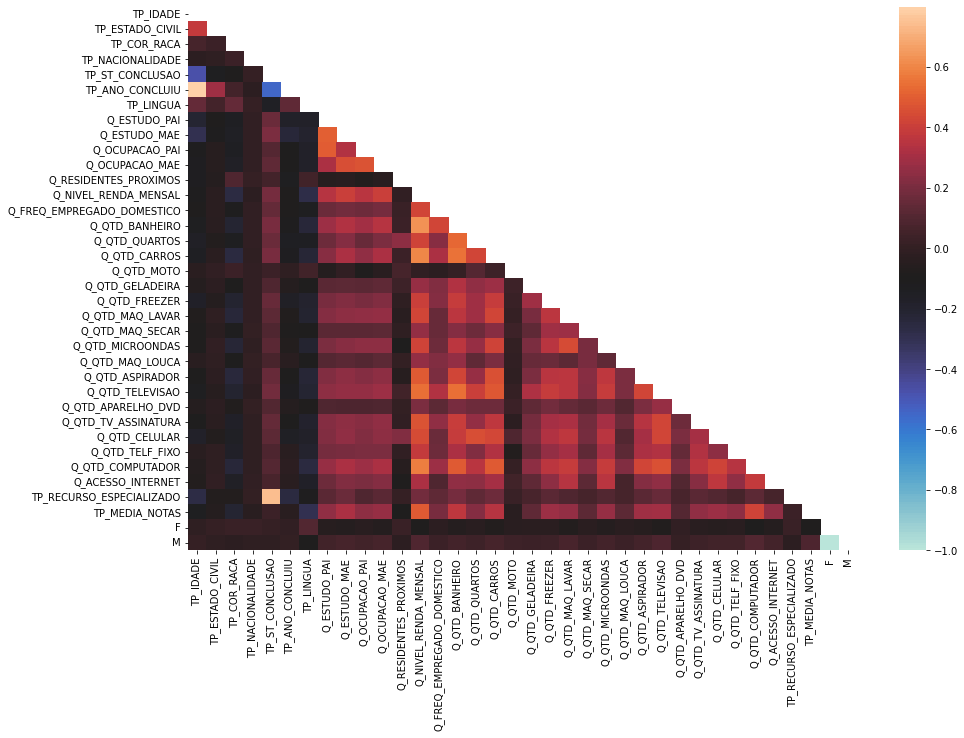

In [22]:
# Graficar mapa de calor
def heat_map(df):
    """Grafica um mapa de calor do dataframe"""
    mask = np.zeros_like(df, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    cmap = sns.color_palette("icefire", n_colors=200)
    sns.heatmap(df, mask=mask,annot=False, cmap=cmap, xticklabels=True, yticklabels=True);
    fig = plt.gcf()
    fig.set_size_inches(15, 10)

df_corr = numeric_features.corr()
heat_map(df_corr)

In [23]:
# Determinar o Fator de Inflação da Variância
variables = df.loc[:,["TP_ANO_CONCLUIU", "TP_IDADE", "TP_ST_CONCLUSAO", "TP_RECURSO_ESPECIALIZADO", 
                      "Q_NIVEL_RENDA_MENSAL"]]
variables["TP_IDADE"] = variables["TP_IDADE"].astype("float64")
variables = variables.dropna()
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
vif["Features"] = variables.columns
vif

,VIF,Features
0,4.503865,TP_ANO_CONCLUIU
1,14.426394,TP_IDADE
2,11.749482,TP_ST_CONCLUSAO
3,2.491262,TP_RECURSO_ESPECIALIZADO
4,2.193918,Q_NIVEL_RENDA_MENSAL


In [ ]:
# Excluir as colunas com indicios de multicolinearidade
df = df.drop(["TP_IDADE","TP_ST_CONCLUSAO"], axis=1)
del variables

Também foi validado se todas as variáveis foram necessarias para a análise mediante um modelo de regressão com o método de ordinary least squares (OLS). Ambos $R^2$ e $R^2 ajustado$ do modelo mostraram um mesmo valor, indicando que nenhuma variável em particular afetou negativamente na precisão do modelo. Os valores do teste de t de Student mostraram que, ao nível de significância de um 5%, as variáveis referentes ao sexo e número de quartos na residência do participante não tinham algum poder preditivo, razão pela qual estas foram excluídas da análise.

In [25]:
# Geração de modelo de regressão com OLS
x = numeric_features.drop(["TP_MEDIA_NOTAS", "TP_IDADE","TP_ST_CONCLUSAO"], axis=1).astype("int64")
y = numeric_features["TP_MEDIA_NOTAS"].astype("float64")
x = sn.add_constant(x)
model = sn.OLS(y,x).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         TP_MEDIA_NOTAS   R-squared:                       0.323
Model:                            OLS   Adj. R-squared:                  0.323
Method:                 Least Squares   F-statistic:                 1.566e+04
Date:                Wed, 08 Dec 2021   Prob (F-statistic):               0.00
Time:                        22:26:13   Log-Likelihood:            -6.0501e+06
No. Observations:             1080727   AIC:                         1.210e+07
Df Residuals:                 1080693   BIC:                         1.210e+07
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                      -4.495e+10   4.43e+10     -1.015      0.310   -1.32e+11    4.19e+10
TP_ESTADO_CIVIL               -8.1804      0.167    -48.938      0.000      -8.508      -7.853
TP_COR_RACA                   -3.6974      0.066    -56.333      0.000      -3.826      -3.569
TP_NACIONALIDADE              -9.4623      0.297    -31.899      0.000     -10.044      -8.881
TP_ANO_CONCLUIU                0.6768      0.019     36.425      0.000       0.640       0.713
TP_LINGUA                    -20.6907      0.135   -153.140      0.000     -20.956     -20.426
Q_ESTUDO_PAI                   1.0814      0.042     25.940      0.000       1.000       1.163
Q_ESTUDO_MAE                   4.1052      0.048     85.122      0.000       4.011       4.200
Q_OCUPACAO_PAI                 0.4908      0.051      9.573      0.000       0.390       0.591
Q_OCUPACAO_MAE                 0.7229      0.053     13.651      0.000       0.619       0.827
Q_RESIDENTES_PROXIMOS         -4.1098      0.049    -84.577      0.000      -4.205      -4.015
Q_NIVEL_RENDA_MENSAL           5.9086      0.029    202.482      0.000       5.851       5.966
Q_FREQ_EMPREGADO_DOMESTICO    -1.9210      0.130    -14.788      0.000      -2.176      -1.666
Q_QTD_BANHEIRO                 7.2966      0.124     58.686      0.000       7.053       7.540
Q_QTD_QUARTOS                  0.0079      0.106      0.075      0.940      -0.199       0.215
Q_QTD_CARROS                   0.7714      0.124      6.222      0.000       0.528       1.014
Q_QTD_MOTO                    -4.7075      0.130    -36.195      0.000      -4.962      -4.453
Q_QTD_GELADEIRA               -8.6229      0.253    -34.055      0.000      -9.119      -8.127
Q_QTD_FREEZER                  7.0805      0.134     52.687      0.000       6.817       7.344
Q_QTD_MAQ_LAVAR               -3.6906      0.155    -23.818      0.000      -3.994      -3.387
Q_QTD_MAQ_SECAR               -6.2245      0.204    -30.468      0.000      -6.625      -5.824
Q_QTD_MICROONDAS               0.8174      0.152      5.379      0.000       0.520       1.115
Q_QTD_MAQ_LOUCA               -3.3036      0.394     -8.384      0.000      -4.076      -2.531
Q_QTD_ASPIRADOR                1.0492      0.193      5.443      0.000       0.671       1.427
Q_QTD_TELEVISAO               -1.4060      0.109    -12.928      0.000      -1.619      -1.193
Q_QTD_APARELHO_DVD            -1.6844      0.143    -11.808      0.000      -1.964      -1.405
Q_QTD_TV_ASSINATURA           -3.1128      0.177    -17.606      0.000      -3.459      -2.766
Q_QTD_CELULAR                  3.2213      0.077     42.045      0.000       3.071       3.371
Q_QTD_TELF_FIXO                1.9619      0.165     11.861      0.000       1.638       2.286
Q_QTD_COMPUTADOR              12.6716      

In [14]:
# Excluir variáveis consideradas irrelevantes para a análise
df = df.drop(["Q_QTD_QUARTOS","F","M"], axis=1)
del numeric_features

## 8. Resultados

### 8.1 Notas por região geográfica

Ao visualizar as médias de notas por estado e região de residência dos participantes, se nota que a região geográfica da prova influenciou nas notas do ENEM 2019. Os participantes que fizeram as provas nos estados das regiões sul e sudeste (com a grande exceção dos participantes no Distrito Federal) tiveram em média melhores notas que os estudantes que participaram das provas em outros estados, assim dando a conhecer uma disparidade nos rendimentos de cada região.

Tal disparidade poderia ser explicada ao visualizar as médias de renda dos participantes e o IDH (Censo Demográfico de 2010) por estado, já que o comportamento dessas variáveis são similares ao das notas, com as regiões Sul e Sudeste tendo no geral os índices mais elevados que o resto do país (excetuando novamente o Distrito Federal).

In [23]:
# Graficar as médias de notas por estado

notas_por_uf = df.groupby(by="SG_UF_PROVA")['SG_UF_PROVA',"TP_MEDIA_NOTAS"].mean().reset_index()

mapa = folium.Map(
    location=[-15.77972, -47.92972],
    zoom_start=3
)

folium.Choropleth(
    geo_data=state_geo,
    name='Média de notas por estado',
    data=notas_por_uf,
    columns=['SG_UF_PROVA','TP_MEDIA_NOTAS'],
    key_on='feature.id',
    fill_color='YlGn',
    fill_opacity=1,
    line_opacity=0.1,
    legend_name='Média de notas'
).add_to(mapa)

# mapa # Descomente esta linha para gerar o mapa

![Mapa 1 - Notas por Estado](https://github.com/kauvinlucas/jupyter-spark-enem-2019/blob/main/assets/images/notas-por-estado.png?raw=true)

In [26]:
# Graficar a média de renta mensal dos participantes por estado

renda_por_uf = df.groupby(by="SG_UF_PROVA")['SG_UF_PROVA',"Q_NIVEL_RENDA_MENSAL"].mean().reset_index()

mapa = folium.Map(
    location=[-15.77972, -47.92972],
    zoom_start=3
)

folium.Choropleth(
    geo_data=state_geo,
    name='Nivel da média de renda por estado',
    data=renda_por_uf,
    columns=['SG_UF_PROVA','Q_NIVEL_RENDA_MENSAL'],
    key_on='feature.id',
    fill_color='YlOrBr',
    fill_opacity=1,
    line_opacity=0.1,
    legend_name='Nivel da média de renda mensal (1 ao 6)'
).add_to(mapa)

# mapa # Descomente esta linha para gerar o mapa

![Mapa 2 - Média de renda mensal por Estado](https://github.com/kauvinlucas/jupyter-spark-enem-2019/blob/main/assets/images/renda-mensal-por-estado.png?raw=true)

In [27]:
# Graficar o índice de IDH por estado

mapa = folium.Map(
    location=[-15.77972, -47.92972],
    zoom_start=3
)

folium.Choropleth(
    geo_data=state_geo,
    name='IDH por estado',
    data=dados_ibge,
    columns=['UF [-]','IDH  Índice de desenvolvimento humano  [2010]'],
    key_on='feature.id',
    fill_color='YlOrBr',
    fill_opacity=1,
    line_opacity=0.1,
    legend_name='IDH'
).add_to(mapa)

# mapa # Descomente esta linha para gerar o mapa

![Mapa 3 - IDH por Estado](https://github.com/kauvinlucas/jupyter-spark-enem-2019/blob/main/assets/images/idh-por-estado.png?raw=true)

Ao visualizar a dispersão das notas, se nota a simple vista que os participantes destacados (com notas de 700 ou mais) dos estados de Ceará e Goiás são proporcionalmente comparáveis ou superiores aos estados com maiores médias de notas no país, apesar das mencionadas regiões terem médias de notas inferiores no geral. Isso foi validado ao comparar com detalhe a distribuição das notas médias das provas nesses respectivos estados versus nos estados com melhores médias de notas. Também se infere que os estados do Acre, Amazonas, Rondônia e Amapá tiveram a menor proporção de participantes destacados em comparação com os demais estados do país.

In [37]:
def graficar_distribuição_notas(df, dict_, output_col, compare=False, compare_cols=[]):
    """Função para graficar as subplots das visualizações geradas com seaborn.distplot e opcionalmente
    graficar conjunto de gráficos com cores diferentes para facilitar a comparação"""
    fig, ax = plt.subplots(len(dict_), figsize=(12, 12))
    for i, row in enumerate(dict_):
        if compare:
            for col in compare_cols:
                if row==col:
                    sns.distplot(df.loc[row, output_col], ax=ax[i], color="Yellow")
                else:
                    sns.distplot(df.loc[row, output_col], ax=ax[i], color="Green")
        else:
            sns.distplot(df.loc[row, output_col], ax=ax[i], color="Green")
        ax[i].set_title("Distribuição das notas {}".format(dict_[row]))
    fig.tight_layout(h_pad=3)

In [55]:
# Graficar as dispersões de notas por estado

notas_por_uf_std = df.groupby(by="SG_UF_PROVA")['SG_UF_PROVA',"TP_MEDIA_NOTAS"].std().reset_index()

mapa = folium.Map(
    location=[-15.77972, -47.92972],
    zoom_start=3
)

folium.Choropleth(
    geo_data=state_geo,
    name='Dispersão de notas por estado',
    data=notas_por_uf_std,
    columns=['SG_UF_PROVA','TP_MEDIA_NOTAS'],
    key_on='feature.id',
    fill_color='YlGn',
    fill_opacity=1,
    line_opacity=0.1,
    legend_name='Desviação estándar das notas'
).add_to(mapa)

# mapa # Descomente esta linha para gerar o mapa

![Mapa 4 - Dispersão de notas por Estado](https://github.com/kauvinlucas/jupyter-spark-enem-2019/blob/main/assets/images/dispersao-notas-por-estado.png?raw=true)

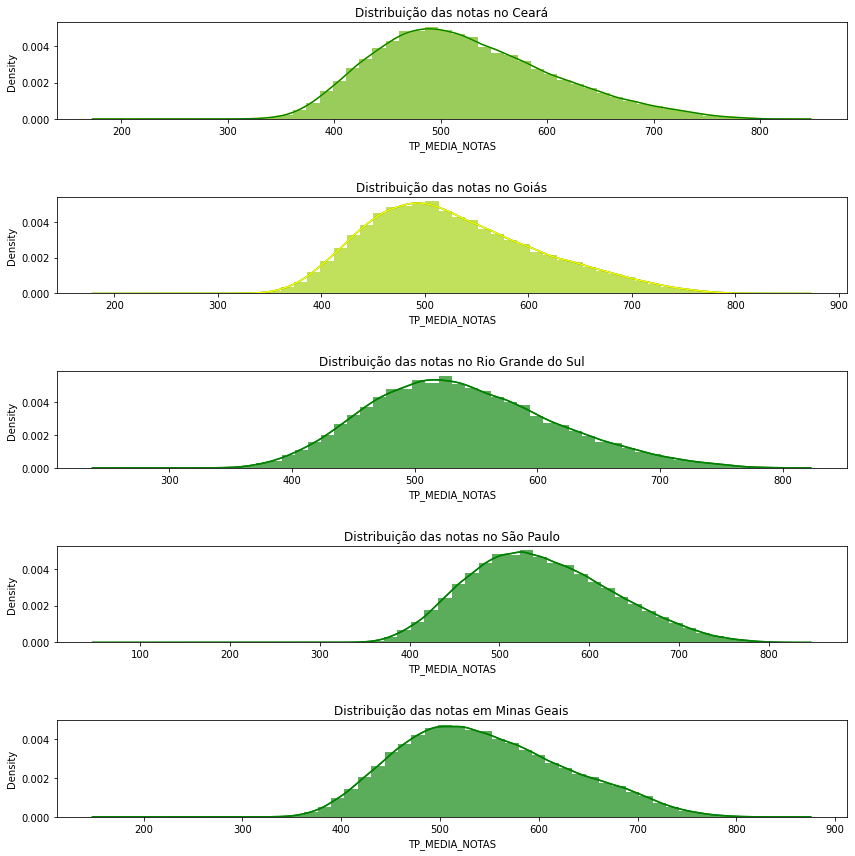

In [38]:
# Graficar uma matriz de distribuições das notas por estados para comparação
states_dict = {"CE":"no Ceará", "GO":"no Goiás", "RS":"no Rio Grande do Sul", "SP":"no São Paulo", 
               "MG":"em Minas Geais"}
output_col = "TP_MEDIA_NOTAS"
graficar_distribuição_notas(df.set_index("SG_UF_PROVA"), 
                            states_dict, 
                            output_col, 
                            compare=True, 
                            compare_cols=["CE","GO"])

### 8.2 Variáveis que mais influenciaram nas notas

Após treinar e analise um modelo de regressão com gradient boosting, evidenciou que as variáveis que mais incidiram nas notas do ENEM foram as relacionadas à renda mensal e à quantidade de computadores na residência do participante. Estas variáveis estão correlacionadas de maneira positiva (ver mapa de calor no ponto 7.2).

O idioma elegido pelo participante para fazer a prova (inglês ou espanhol) também influenciou notavelmente nas notas. Os participantes que fizeram a prova de lingua espanhola tiveram em média um peor desempenho dos que fizeram a de lingua inglesa. As outras variáveis que tiveram destaque em menor medida foram:

* A quantidade de banheiros na residência do participante. Esta variável está fortemente correlacionado com a renda mensual (ver mapa de calor no ponto 7.2)
* Se o participante solicitou recurso para atendimento especializado nos dias da provas.

Text(0, 0.5, 'Atributos')

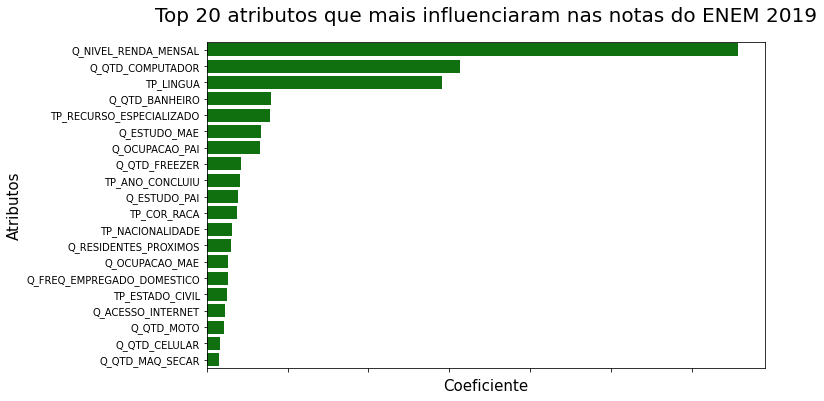

In [23]:
def graficar_atributos_mais_importantes(x,y):
    """Função para graficar os atributos mais importantes de acordo com o modelo de regressão linear"""
    model = XGBRegressor()
    sc = StandardScaler()
    x_sc = sc.fit_transform(x)
    model.fit(x_sc,y)
    coefs = pd.DataFrame(columns=x.columns)
    coefs = coefs.transpose().reset_index()
    coefs.columns = ["Atributos"]
    coefs["Coeficientes"] = model.feature_importances_
    coefs["abs_value"] = coefs["Coeficientes"].apply(lambda x: abs(x))
    coefs["colors"] = coefs["Coeficientes"].apply(lambda x: "green" if x > 0 else "Red")
    coefs = coefs.sort_values("abs_value", ascending=False)
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    sns.barplot(x="Coeficientes",
                y="Atributos",
                data=coefs.head(20),
               palette=coefs.head(20)["colors"])
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=10)
    ax.set_title("Top 20 atributos que mais influenciaram nas notas do ENEM 2019", fontsize=20, pad=20)
    ax.set_xlabel("Coeficiente", fontsize=15)
    ax.set_ylabel("Atributos", fontsize=15)

# Graficar os atributos que mais influenciaram nas notas no modelo de regressão linear
features = df.drop(["SG_UF_RESIDENCIA","SG_UF_NASCIMENTO", "SG_UF_PROVA"], axis=1)
x = features.drop(["TP_MEDIA_NOTAS"], axis=1).astype("int64")
y = features["TP_MEDIA_NOTAS"].astype("float64")
graficar_atributos_mais_importantes(x,y)

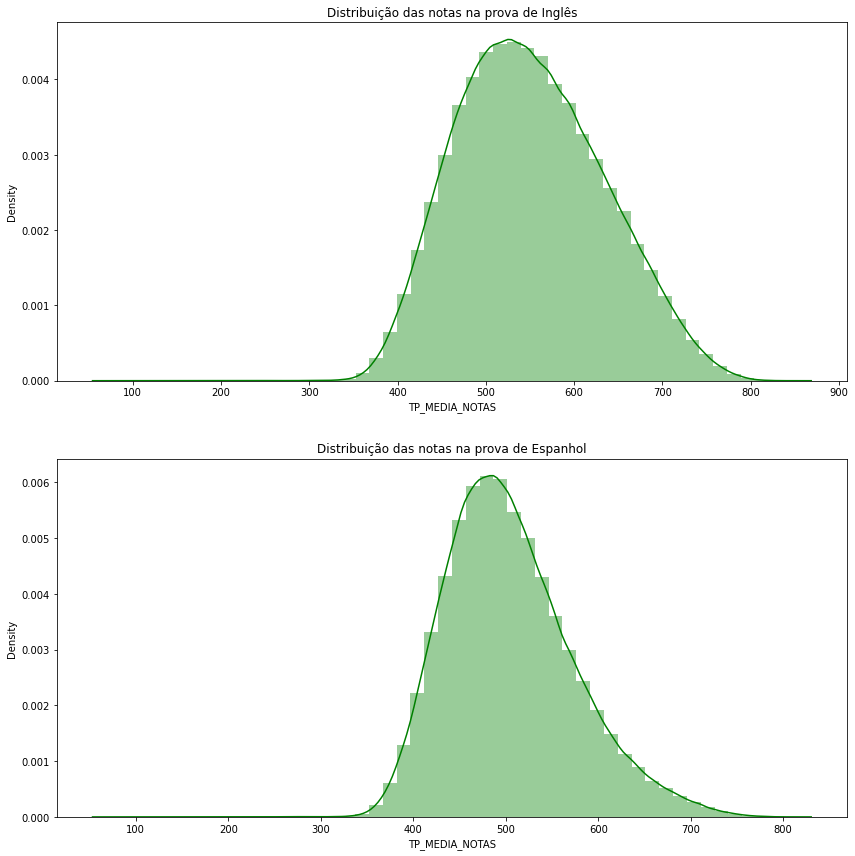

In [39]:
# Graficar a comparação das distribuições dos atributos de idioma escolhido
ling_dict = {0:"na prova de Inglês", 1:"na prova de Espanhol"}
graficar_distribuição_notas(df.set_index("TP_LINGUA"), ling_dict, "TP_MEDIA_NOTAS")

### 9. Considerações finais

Este projeto mostrou as etapas consideradas necessárias para a extração, transformação e análise dos microdados referentes ao periodo de 2019 diponibilizados pelo ENEM, para o problema e os objetivos de análise definidos. A análise descritiva sobre estes dados conseguiu extrair algums dos fatores que influenciaram nas notas do ENEM. Este fatores estão persistentemente ligados aos aspectos socioeconômicos dos participantes das provas. O nível de renda dos familiares dos participantes demostrou ser o fator principal de influência. Tendo em conta a revisão da literatura relacionada ao tema e a importancia do ENEM para a inserção dos estudantes de ensino médio nas universidades do país, os resultados da análise uma vez mais realçam a necessidade de políticas públicas voltadas a melhorar a renda média de cada familia para que as disparidades na sejam refletidas nos resultados das provas.

## 10. Referências

Melo, R. O., Freitas, A. C. de, Francisco, E. de R., & Motokane, M. T. (2021). *Impacto das variáveis socioeconômicas no desempenho do Enem: uma análise espacial e sociológica*. Revista De Administração Pública. Recuperado de https://bibliotecadigital.fgv.br/ojs/index.php/rap/article/view/84874

Instituto Nacional de Estudos e Pesquisas Educacionais Anísio Teixeira (2019). *Microdados do Enem 2019*. Recuperado em 20 de junho de 2020, de http://portal.inep.gov.br/web/guest/microdados.